In [2]:
import os
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
stock_data = pd.read_csv('D:/Python_Projects/Regression/TSLA.csv').fillna(0)

In [6]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


<AxesSubplot: ylabel='Close'>

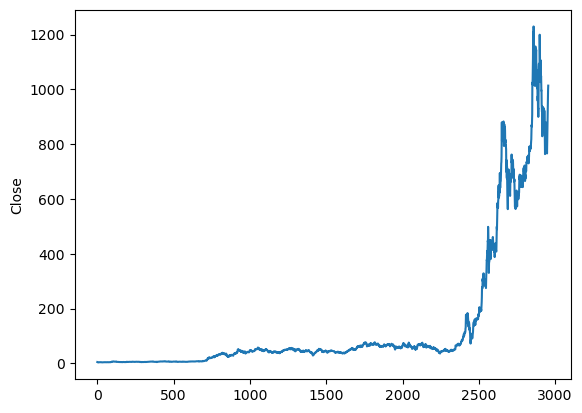

In [7]:
sns.lineplot(stock_data.Close)

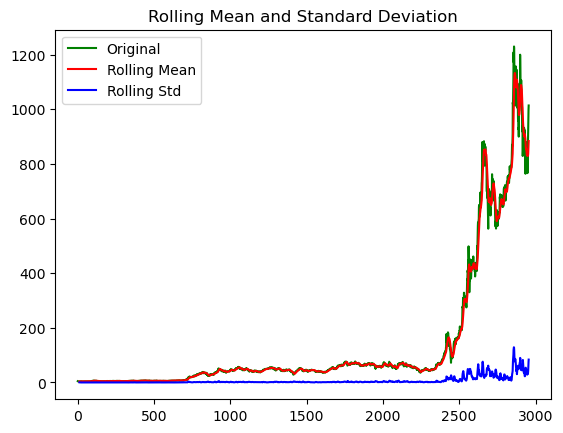

Dickey-Fuller test
Test Statistics                   1.423942
p-value                           0.997220
No. of lags used                 28.000000
Number of observations used    2927.000000
critical value (1%)              -3.432586
critical value (5%)              -2.862528
critical value (10%)             -2.567296
dtype: float64


In [52]:
# Stationarity checking
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='green',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print('Dickey-Fuller test')
    adft = adfuller(timeseries)
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data.Close)

<Figure size 640x480 with 0 Axes>

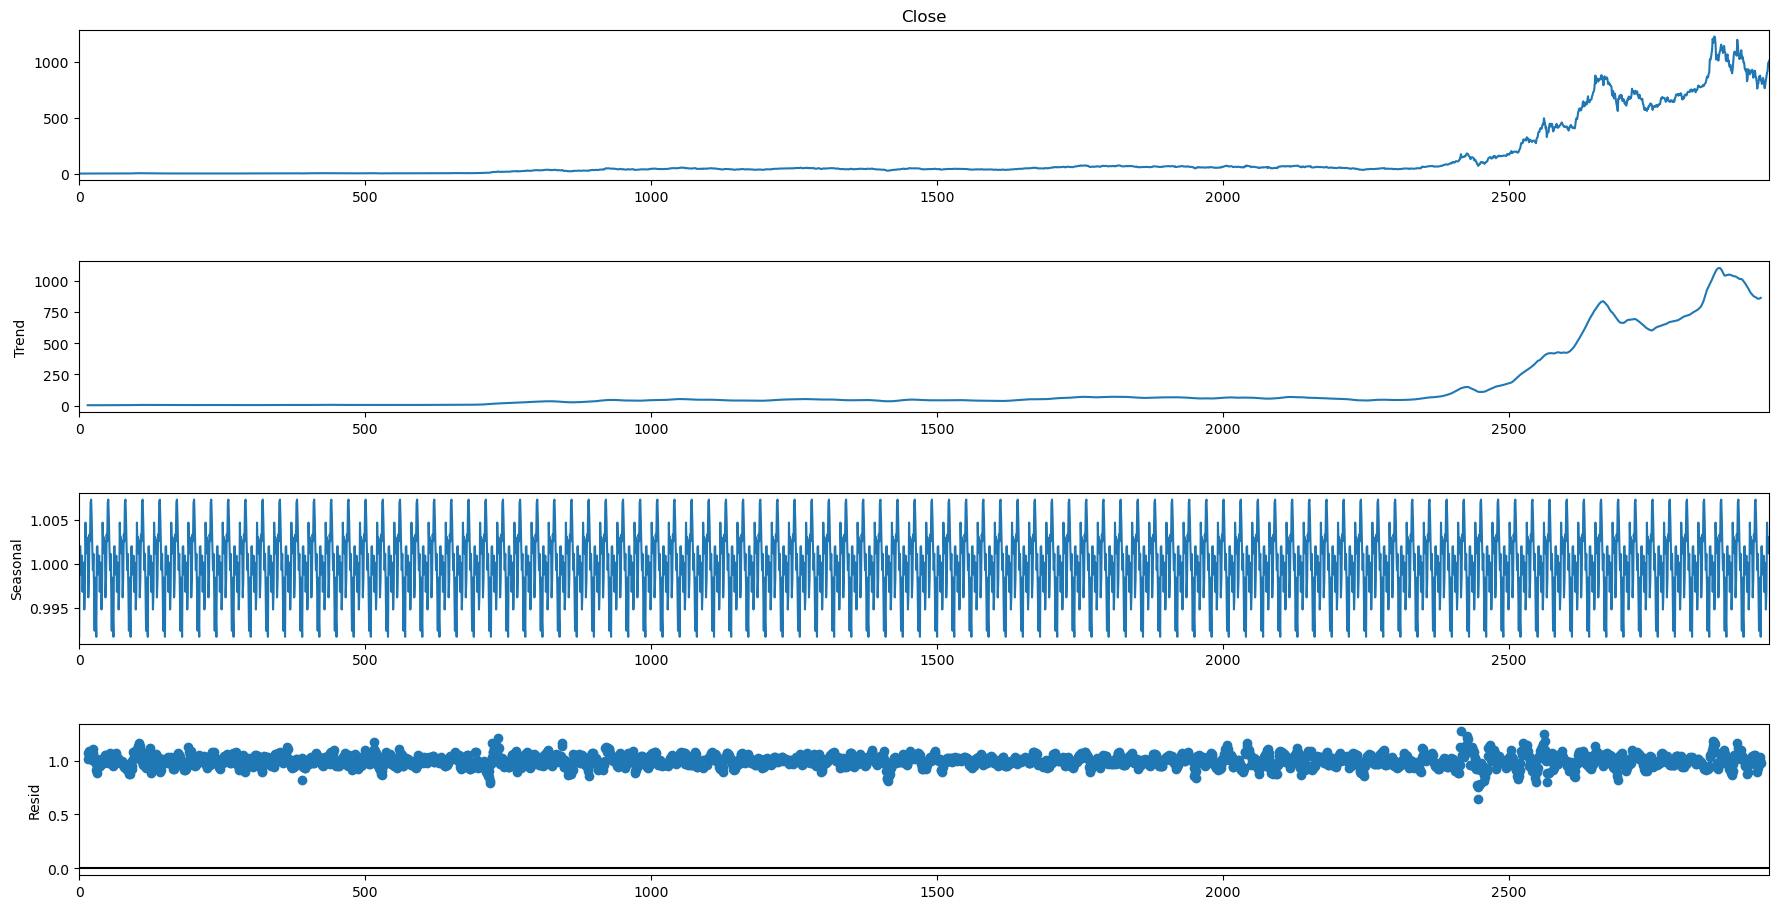

In [61]:
# To stationarity
result = seasonal_decompose(stock_data.Close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 10)

In [62]:
# Get rid of the trend
df_log = np.log(stock_data.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


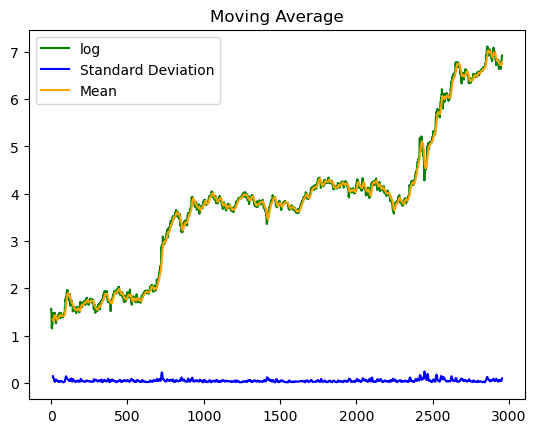

In [63]:
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(df_log, color="green", label = "log")
plt.plot(std_dev, color ="blue", label = "Standard Deviation")
plt.plot(moving_avg, color="orange", label = "Mean")
plt.legend()
plt.show()

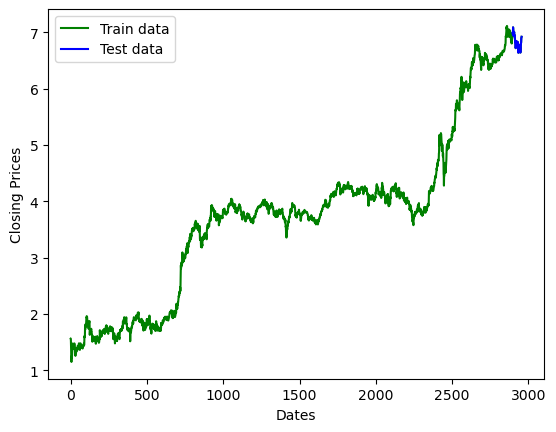

In [64]:
train_data, test_data = df_log[3:int(len(df_log)*0.98)], df_log[int(len(df_log)*0.98):]
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [65]:
# ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # to find optimum d
                      max_p=3, max_q=3, # set max for p and q
                      m=1,              # seasonality period (don't search)
                      d=None,           # determined with adf
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11158.698, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11156.796, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11156.796, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11151.774, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11154.753, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.260 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2893
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5581.349
Date:                Thu, 20 Apr 2023   AIC                         -11158.698
Time:                        15:10:42   BIC                         -11146.759
Sample:                             0   HQIC                        -11154.396
                               - 2893                             

In [66]:
model_autoARIMA.fit(train_data)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [67]:
forecast = model_autoARIMA.predict(n_periods=len(test_data))

In [68]:
forecast.index = test_data.index

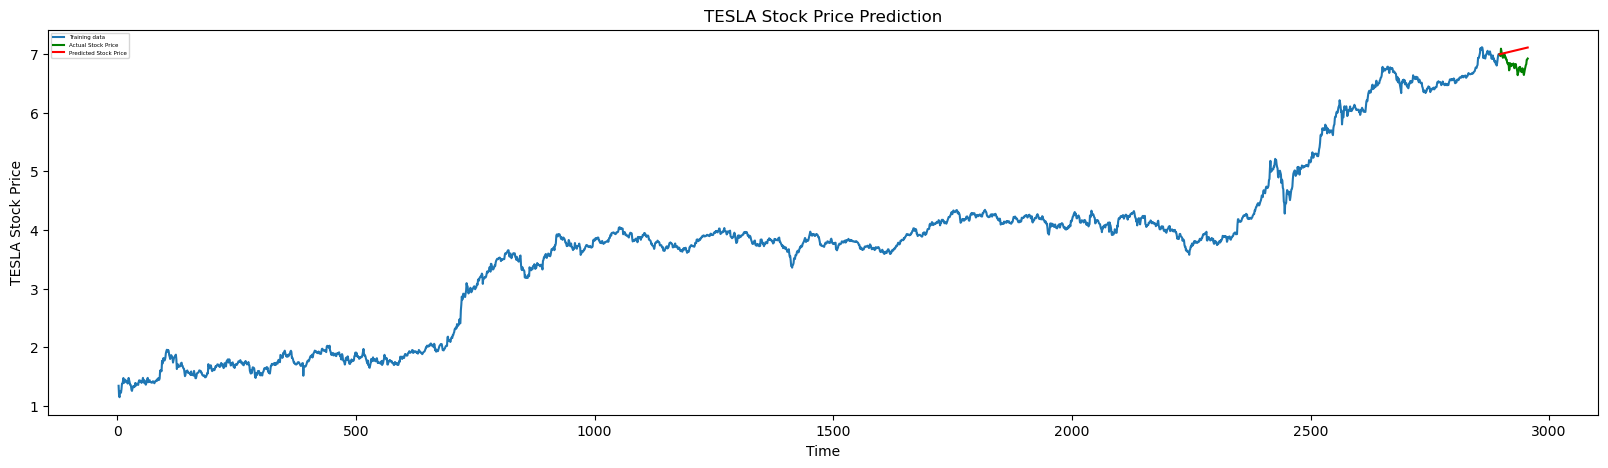

In [69]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'green', label='Actual Stock Price')
plt.plot(forecast, color = 'red',label='Predicted Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend(loc='upper left', fontsize=4)
plt.show()

In [70]:
mean_squared_error(test_data, forecast), mean_absolute_error(test_data, forecast)

(0.0672214566286044, 0.22757221374222977)